# PSBC - ensemble learning notebook


Goal: perform PSBC model evaluation on a grid in the folder "../Grids", on the main folder.

How: 

Input: 
* Neumann: bool (True or False), denotes the type of Boundary condition.
* subordinate: bool (True or False, default is True) to describe the type of model
* parallel: bool (True or False, default is False), in case the model is parallel
* with_PCA: bool (True or False, default is False), in case a different basis matrix is used


Initially, we need to allow google drive to access the folders with files.


Most of this notebook came from notebooks 
* PSBC_confusion_matrix_classifier_196
* PSBC_confusion_matrix_PCA
* Full_classifier_tournament_August

In [2]:
Colab = False

In [3]:
if Colab:
    from google.colab import drive
    drive.mount ('/content/drive')

In [4]:
#import  matplotlib.pyplot as plt
import scipy.sparse as sc
import itertools as it
import pandas as pd
import numpy as np
import warnings
import shutil 
import copy
import glob
import sys
import os
import time
import tensorflow as tf
from tensorflow import keras
try: ## In order to open and save dictionaries, "dt": self.dt, "kind" : "Viscosity"
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import multiprocess as mp

import matplotlib.pyplot as plt

IMAGES = "images"
warnings.filterwarnings (action="ignore",message="internal issue")

In [5]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [6]:
sys.path.insert (0, "MOTHER_PSBC/")
from tfversion_binary_phase_separation import *
from tf_PSBC_extra_libs_for_training_and_grid_search import *

### THere is a new library that will be necessary
from tf_PSBC_extra_libs_for_classifier import *
from PSBC_plots_useful import *

# Ensemble learning



In [7]:
with open ("Statistics/All_confusion_matrices.p", 'rb') as pickled_dic:
    All_confusion_matrices = pickle.load (pickled_dic)

In [9]:
All_confusion_matrices ["Classifier_196"][2][(0,1)]

{'accuracy': 0.9881796690307328,
 'f1_score': 0.9890686488850022,
 'raw': array([[ 959,   21],
        [   4, 1131]]),
 'relative': array([[0.9785714 , 0.02142857],
        [0.00352423, 0.99647576]], dtype=float32)}


Accuracy for PSBC
(canonical base matrix) is 0.8463083877448518

F1 score for PSBC
(canonical base matrix) is 0.8542857142857142

Accuracy for PSBC (PCA) is 0.8463083877448518

F1 score for PSBC (PCA) is 0.8489634748272458
Saving figure as  confusion_matrices_4_9


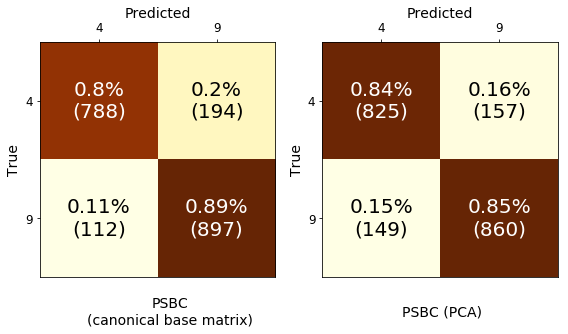


Accuracy for PSBC
(canonical base matrix) is 0.8349106203995794

F1 score for PSBC
(canonical base matrix) is 0.8092345078979344

Accuracy for PSBC (PCA) is 0.8475289169295478

F1 score for PSBC (PCA) is 0.832175925925926
Saving figure as  confusion_matrices_3_5


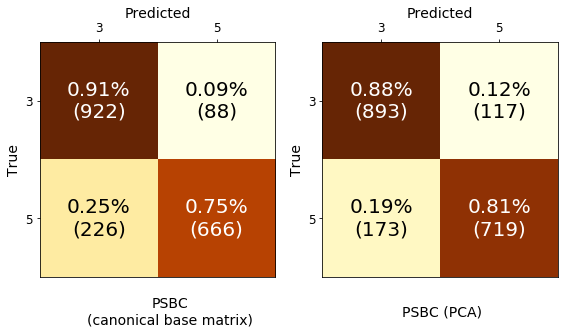

In [9]:
pairs_of_digits = [(4,9), (3, 5)]

for pair_now in pairs_of_digits:

    variable_0 , variable_1 = pair_now
    lks_range = {2 : [1]} 
    
    fig, ax = plt.subplots (ncols = 2, figsize = (8, 6))

    title = ["PSBC\n(canonical base matrix)", "PSBC (PCA)"]
    
    for i,folder_name in enumerate (["Classifier_196", "PCA_196"]):
        
        Dict_now = All_confusion_matrices [folder_name][2][(variable_0,variable_1)]
        
        print ("\nAccuracy for " +str (title[i]) + " is "+ str (Dict_now ["accuracy"]))
        print ("\nF1 score for " +str (title[i]) + " is "+ str (Dict_now ["f1_score"]))
        Matrix_now = Dict_now ["relative"]
        Matrix_raw = Dict_now ["raw"]

        ax [i].imshow (Matrix_now , cmap=plt.cm.YlOrBr)
        ax [i].set_xticks ([0, 1])
        ax [i].set_xlabel ("Predicted", size = 14)
        ax [i].set_ylabel ("True", size = 14)
        ax [i].xaxis.set_label_position ('top')
        ax [i].set_xticklabels ([variable_0, variable_1], size = 12)
        ax [i].set_yticks ([0,1])
        ax [i].set_yticklabels ([variable_0, variable_1], size = 12)
        ax [i].xaxis.set_ticks_position ('top') 

    
        for y in range (2):
            for x in range (2):
                label = str (np.round(Matrix_now[y, x],decimals=2))+"%\n("+str (Matrix_raw[y, x])+")"
                text_x = x 
                text_y = y 
                color = "black" if x != y else "white"
                ax [i].text (text_x, text_y, label,
                                 color = color, ha = 'center', va = 'center', size= 20)

    aux = ax [0].get_position ()
    fig.text(
        aux.x0 + aux.width / 2, aux.y0 - .12, title [0],
        ha = 'center', va = 'center', rotation = 0, size = 14)    

    aux = ax [1].get_position ()
    fig.text(
        aux.x0 + aux.width / 2 +.05, aux.y0 - .12, title[1],
        ha = 'center', va = 'center', rotation = 0, size = 14)    
    #figure_save ("confusion_matrices_"+str (variable_0)+"_"+str (variable_1), resolution = 600)
    plt.show ()

# Retrieving the MNIST database to use multiclass classifier


Thi sis from 

Full_classifier_tournament_August, PSBC_confusion_matrix_PCA, and 
PSBC_confusion_matrix_classifier_196

In [11]:
with open ('Statistics/All_confusion_matrices_multiclass.p', 'rb') as  pickled_dic:
    All_confusion_matrices_multiclass = pickle.load (pickled_dic)


In [13]:
All_confusion_matrices_multiclass ["Classifier_196"][2].keys()

dict_keys(['hard_vote', 'tournament'])

In [12]:
M_now = All_confusion_matrices_multiclass ["Classifier_196"][2]\
    ["hard_vote"]["relative"]
M_now

array([[8.06122422e-01, 2.04081624e-03, 1.22448979e-02, 2.55102050e-02,
        3.06122447e-03, 7.85714313e-02, 4.69387770e-02, 3.06122447e-03,
        1.83673464e-02, 4.08163248e-03],
       [0.00000000e+00, 9.58590329e-01, 8.81057291e-04, 3.52422916e-03,
        0.00000000e+00, 1.76211458e-03, 2.64317170e-03, 0.00000000e+00,
        3.25991176e-02, 0.00000000e+00],
       [2.32558139e-02, 3.77906971e-02, 7.35465109e-01, 6.10465109e-02,
        2.81007756e-02, 3.87596898e-03, 4.26356606e-02, 1.25968996e-02,
        5.13565876e-02, 3.87596898e-03],
       [6.93069305e-03, 3.66336629e-02, 2.37623770e-02, 8.14851463e-01,
        1.98019808e-03, 2.87128706e-02, 9.90098994e-03, 2.17821784e-02,
        4.35643569e-02, 1.18811885e-02],
       [1.01832999e-03, 5.09164967e-02, 3.05498973e-03, 0.00000000e+00,
        7.54582465e-01, 2.03665998e-03, 2.24032588e-02, 1.01832999e-03,
        2.03665998e-03, 1.62932783e-01],
       [3.92376669e-02, 1.00896858e-01, 8.96861032e-03, 2.20852017e-01,
   

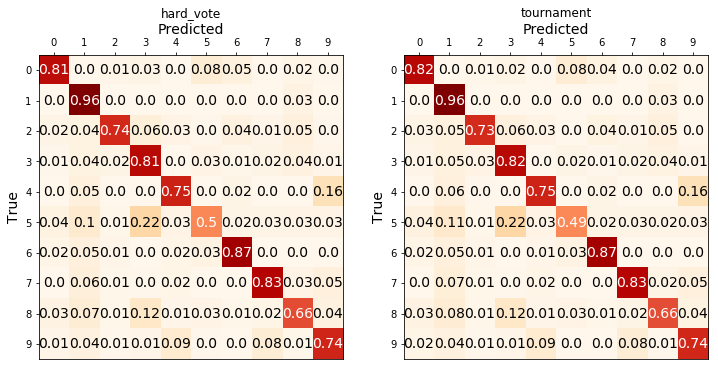

In [12]:
fig, ax = plt.subplots (ncols=2, figsize = (12, 6))


for i, type_of_vote in enumerate (["hard_vote", "tournament"]):
    
    M_now = All_confusion_matrices_multiclass ["Classifier_196"][2]\
    [type_of_vote]["relative"]
    
    ax [i].imshow (M_now, cmap=plt.cm.OrRd)
    ax [i].set_title (type_of_vote)
    ax [i].xaxis.set_ticks_position ('top')
    ax [i].set_xticks (np.arange (10))
    ax [i].set_xticklabels (np.arange (10))
    ax [i].set_yticks (np.arange (10))
    ax [i].set_yticklabels (np.arange (10))
    ax [i].set_xlabel ("Predicted", size = 14)        
    ax [i].set_ylabel ("True", size = 14)
    ax [i].xaxis.set_label_position('top') 
    for y in range (10):
        for x in range (10):
            label = str (np.round (M_now [y, x], decimals = 2))
            text_x = x 
            text_y = y 
            color = "black" if x != y else "white"
            ax [i].text (text_x, text_y, label, color = color, ha = 'center', va = 'center', size= 14)

plt.show ()

In [13]:
All_confusion_matrices["Classifier_196"][2]\
        [(variable_0,variable_1)]

{'accuracy': 0.8349106203995794,
 'f1_score': 0.8092345078979344,
 'raw': array([[922,  88],
        [226, 666]]),
 'relative': array([[0.9128713 , 0.08712871],
        [0.25336322, 0.74663675]], dtype=float32)}

Saving figure as  tournament5_confusion_matrices


/home/rafa-monteiro/.local/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


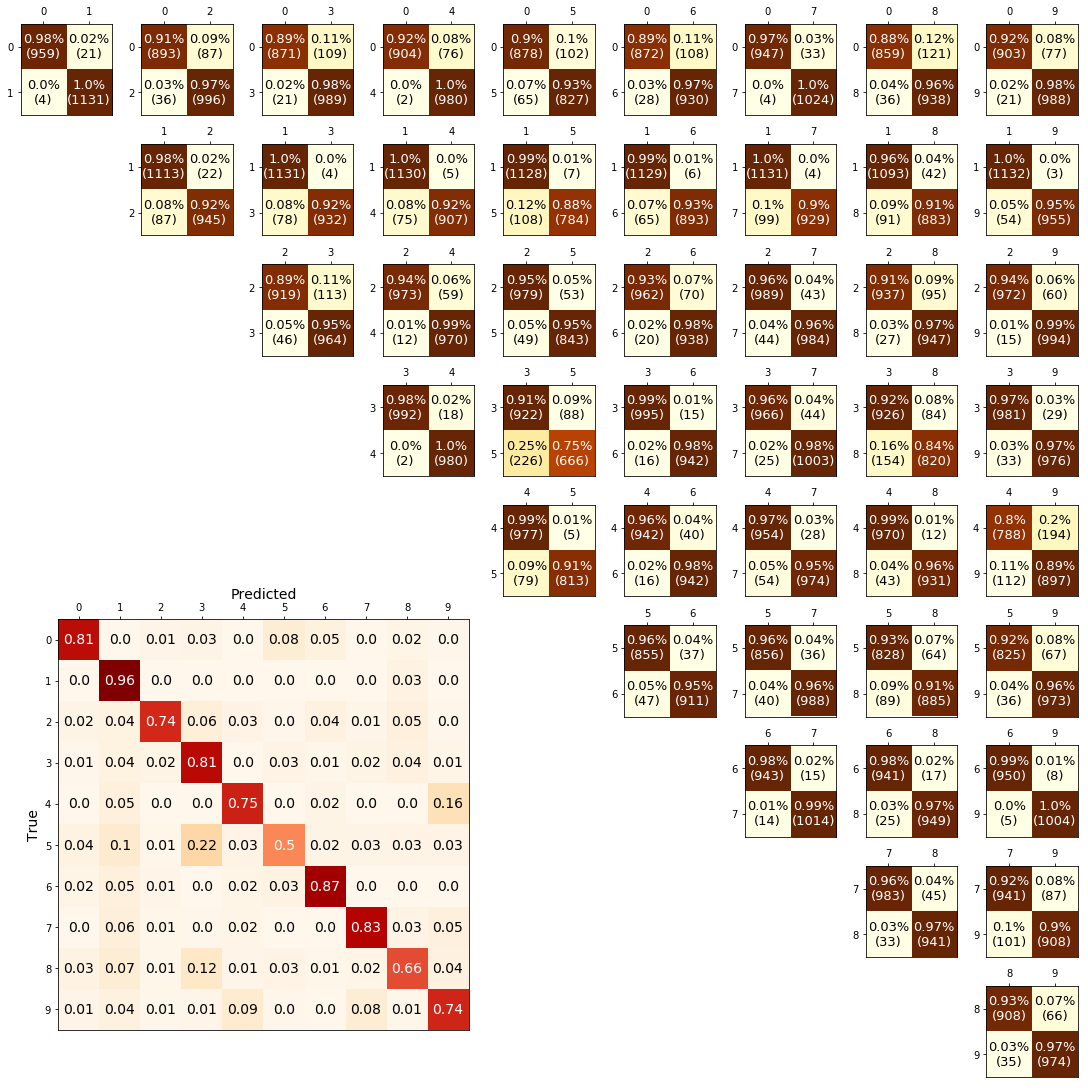

In [14]:
fig = plt.figure (figsize = (15, 15), constrained_layout = True)
spec = fig.add_gridspec (ncols = 9, nrows = 9, wspace = .11)

for a in range (10):
    for b in range (a,9):
        # gridspec inside gridspec
        variable_0 = a
        variable_1 = b + 1
        ax = fig.add_subplot (spec [a, b])
        
        M_now = All_confusion_matrices ["Classifier_196"][2][(variable_0,variable_1)]
    
        Matrix_now = M_now ["relative"]
        Matrix_raw = M_now ["raw"]
        ax.imshow(Matrix_now , cmap = plt.cm.YlOrBr)
        ax.set_xticks ([0, 1])
        ax.set_xticklabels ([variable_0, variable_1])
        ax.set_yticks ([0,1])
        ax.set_yticklabels ([variable_0, variable_1])
        ax.xaxis.set_ticks_position ('top') 
        
        for y in range (2):
            for x in range (2):
                label = str (np.round (Matrix_now [y, x], decimals = 2)) + "%\n(" +\
                str (Matrix_raw[y, x]) + ")"
                text_x = x 
                text_y = y 
                color = "black" if x != y else "white"
                ax.text (text_x, text_y, label, color = color, ha = 'center', va = 'center', size = 13)

M_max = All_confusion_matrices_multiclass ["Classifier_196"][2]["hard_vote"]["relative"]

ax2 = fig.add_axes ([0.05, 0.05, .38, .38])
ax2.imshow (M_max, cmap = plt.cm.OrRd)
ax2.xaxis.set_ticks_position ('top')
ax2.set_xticks (np.arange (10))
ax2.set_xticklabels (np.arange (10))
ax2.set_yticks (np.arange (10))
ax2.set_yticklabels (np.arange (10))
ax2.set_xlabel ("Predicted", size = 14)        
ax2.set_ylabel ("True", size = 14)
ax2.xaxis.set_label_position ('top') 
for y in range (10):
    for x in range (10):
        label = str (np.round (M_max [y, x], decimals = 2))
        text_x = x 
        text_y = y 
        color = "black" if x != y else "white"
        ax2.text(text_x, text_y, label, color = color, ha = 'center', va = 'center', size= 14)

#figure_save("tournament"+str (how_many)+\
#            "_confusion_matrices", figure_extension="pdf", resolution = 600)        
plt.show ()

The accuracy of the multiclass classifier is

In [15]:
All_confusion_matrices_multiclass ["Classifier_196"][2]["hard_vote"]["accuracy"]

0.7725

while using tournaments, the accuracy is

In [16]:
All_confusion_matrices_multiclass ["Classifier_196"][2]["tournament"]["accuracy"]

0.772

# Creating matrix with accuracies

In [17]:
with open ('Statistics/All_accuracies.p', 'rb') as  pickled_dic:
    All_accuracies = pickle.load (pickled_dic)

In [18]:
which_group = "test"
mean_matrix = np.zeros ((10,10))
std_matrix = np.zeros ((10,10))


for index in range (45):
    variable_0, variable_1  = grid_indexes [index]
    
    all_stats_classifier = All_accuracies ["Classifier_196"]\
    [2][(variable_0, variable_1)][1]
    mean_matrix[variable_0,variable_1] = all_stats_classifier["test_set_mean"]
    std_matrix[variable_0,variable_1] = all_stats_classifier["test_set_std"]


In [19]:
f = pd.DataFrame(columns = np.arange (10), data = [])
for index in range (45):
    variable_0, variable_1  = grid_indexes [index]
    
    f.at [variable_0,variable_1] = str (np.round(mean_matrix[variable_0,variable_1],2)) +\
    "\pm" + str (np.round (std_matrix [variable_0,variable_1], 2))

In [20]:
f

,0,1,2,3,4,5,6,7,8,9
0,NaN,0.99\pm0.0,0.94\pm0.0,0.93\pm0.0,0.96\pm0.0,0.91\pm0.01,0.93\pm0.0,0.98\pm0.0,0.92\pm0.0,0.95\pm0.0
1,NaN,NaN,0.95\pm0.0,0.96\pm0.0,0.96\pm0.0,0.94\pm0.0,0.97\pm0.0,0.95\pm0.0,0.94\pm0.0,0.97\pm0.0
2,NaN,NaN,NaN,0.92\pm0.01,0.97\pm0.0,0.95\pm0.0,0.95\pm0.0,0.96\pm0.0,0.94\pm0.0,0.96\pm0.0
3,NaN,NaN,NaN,NaN,0.99\pm0.0,0.83\pm0.01,0.98\pm0.0,0.97\pm0.0,0.88\pm0.0,0.97\pm0.0
4,NaN,NaN,NaN,NaN,NaN,0.95\pm0.0,0.97\pm0.0,0.96\pm0.0,0.97\pm0.0,0.84\pm0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,0.95\pm0.0,0.96\pm0.0,0.92\pm0.0,0.95\pm0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99\pm0.0,0.98\pm0.0,0.99\pm0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.96\pm0.0,0.9\pm0.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95\pm0.0


In [21]:
%f.to_latex ()

UsageError: Line magic function `%f.to_latex()` not found.
